In [ ]:
#importing modules
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import pickle
from shutil import copy2
import tensorflow
import IPython

import keras
keras.backend.clear_session()

In [ ]:
#mounting drive on colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#checking if we are connected to a gpu runtime
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
#printing the name of GPU we're connected to
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-ec937ac5-045f-d81a-f23d-01e690d8f7f9)


In [ ]:
#performing data augmentation
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_dir='/content/drive/My Drive/btp data/exp2/train/'
validation_dir='/content/drive/My Drive/btp data/exp2/val/'
test_dir='/content/drive/My Drive/btp data/exp2/test/'

In [ ]:
#loading data into generators
train_generator = train_datagen.flow_from_directory(
        train_dir,   
        batch_size=32,
        color_mode='rgb',
        shuffle=True,
        target_size=(224, 224),
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        batch_size=32,
        color_mode='rgb',
        shuffle=True,
        target_size=(224, 224),
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        batch_size=32,
        color_mode='rgb',
        shuffle=False,
        target_size=(224, 224),
        class_mode=None)

Found 10360 images belonging to 37 classes.
Found 2220 images belonging to 37 classes.
Found 2240 images belonging to 37 classes.


In [ ]:
#importing pretrained vgg16 model
from keras.applications.vgg16 import VGG16

base_model=VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
#defining transfer learning model architecture
from keras.layers import Dense, Flatten, Dropout
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense,GlobalAveragePooling2D
from keras.models import Model
from tensorflow.keras.regularizers import l2

output=base_model.layers[-1].output
output=Flatten()(output)
base_model=Model(base_model.input,output)
for layer in base_model.layers:
    layer.trainable = False
base_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
#adding custom fully connected layers at the end of pretrained model
model1=Sequential()
model1.add(base_model)
model1.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model1.add(Dropout(0.3))
model1.add(Dense(37, activation='softmax', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 25088)             14714688  
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 37)                18981     
                                                                 
Total params: 27,579,237
Trainable params: 12,864,549
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
#defining metrics for our model
from keras.metrics import top_k_categorical_accuracy

def top3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

model1.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-6),
              metrics=['accuracy', top3_accuracy])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
#defining required callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping
callback = EarlyStopping(monitor='val_loss',min_delta=0, 
                                            patience=20, mode='auto',verbose=0, restore_best_weights=True)

checkpoint_path = '/content/drive/My Drive/btp data/exp2/checkpointvgg16.h5'
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                                   save_weights_only=True,
                                   verbose=1)

In [ ]:
#training our model for 200 epochs
history = model1.fit_generator(
      train_generator,
      epochs=200,
      validation_data=validation_generator,
      callbacks=[callback, cp_callback],
      verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/200
324/324 [==============================] - ETA: 0s - loss: 14.3741 - accuracy: 0.0353 - top3_accuracy: 0.1019
Epoch 00001: saving model to /content/drive/My Drive/btp data/exp2/checkpointvgg16.h5
324/324 [==============================] - 2645s 8s/step - loss: 14.3741 - accuracy: 0.0353 - top3_accuracy: 0.1019 - val_loss: 14.0139 - val_accuracy: 0.0595 - val_top3_accuracy: 0.1514
Epoch 2/200
324/324 [==============================] - ETA: 0s - loss: 13.9450 - accuracy: 0.0557 - top3_accuracy: 0.1426
Epoch 00002: saving model to /content/drive/My Drive/btp data/exp2/checkpointvgg16.h5
324/324 [==============================] - 124s 381ms/step - loss: 13.9450 - accuracy: 0.0557 - top3_accuracy: 0.1426 - val_loss: 13.6579 - val_accuracy: 0.1099 - val_top3_accuracy: 0.2536
Epoch 3/200
324/324 [==============================] - ETA: 0s - loss: 13.5903 - accuracy: 0.0810 - top3_accuracy: 0.1940
Epoch 00003: saving model to /content/drive/My Drive/btp data/exp2/checkpointvgg16.h5


In [ ]:
#saving model to disk storage
from joblib import dump
dump(model1,'/content/drive/My Drive/btp data/exp2/vggmodel200.joblib')
model1.save('/content/drive/My Drive/btp data/exp2/vggmodeldemo.h5')

INFO:tensorflow:Assets written to: ram://e08080b1-b10b-421b-986f-6eb02b8663d4/assets


Text(0.5, 1.0, 'Training and validation loss')

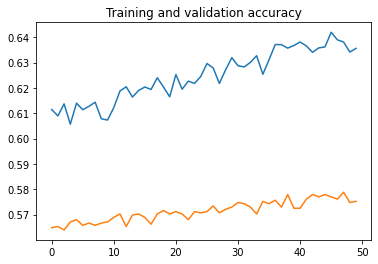

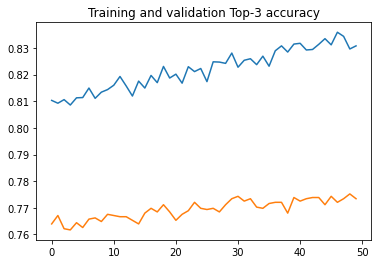

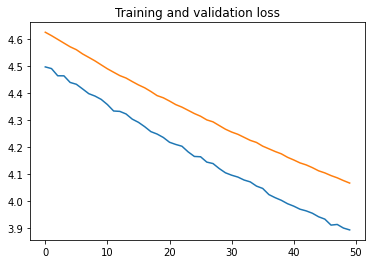

In [ ]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
top3acc = history.history['top3_accuracy']
val_top3acc = history.history['val_top3_accuracy']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, top3acc)
plt.plot(epochs, val_top3acc)
plt.title('Training and validation Top-3 accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [ ]:
Y_pred = model1.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


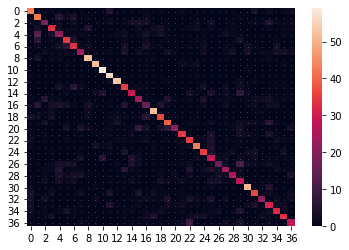

In [ ]:
#generating heatmap
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import seaborn as sns
cm = confusion_matrix(test_generator.classes, y_pred)
f = sns.heatmap(cm, annot=True, annot_kws={"size": 1})

In [ ]:
#printing model performance wrt defined metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(test_generator.classes, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(test_generator.classes, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(test_generator.classes, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(test_generator.classes, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(test_generator.classes, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(test_generator.classes, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(test_generator.classes, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(test_generator.classes, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(test_generator.classes, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(test_generator.classes, y_pred, average='weighted')))

category_names=sorted(os.listdir('/content/drive/My Drive/btp data/exp2/train'))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(test_generator.classes, y_pred, target_names=category_names))


Accuracy: 0.57

Micro Precision: 0.57
Micro Recall: 0.57
Micro F1-score: 0.57

Macro Precision: 0.57
Macro Recall: 0.57
Macro F1-score: 0.56

Weighted Precision: 0.57
Weighted Recall: 0.57
Weighted F1-score: 0.56

Classification Report

                            precision    recall  f1-score   support

            Albrecht Durer       0.61      0.72      0.66        60
             Alfred Sisley       0.54      0.70      0.61        60
           Boris Kustodiev       0.43      0.30      0.35        60
             Camille Corot       0.55      0.55      0.55        60
          Camille Pissarro       0.34      0.35      0.35        60
             Childe Hassam       0.55      0.58      0.56        60
              Claude Monet       0.52      0.47      0.49        70
               Edgar Degas       0.51      0.40      0.45        60
             Eugene Boudin       0.70      0.87      0.78        60
              Eyvind Earle       0.79      0.87      0.83        60
             

In [ ]:
#defining cnn model architecture for our data
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import keras

initializer = keras.initializers.he_normal()
model = Sequential()

model.add(Conv2D(16, (3,3), activation='relu', padding='same', kernel_initializer=initializer, input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer=initializer))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer=initializer))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(37, activation='softmax', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))

In [ ]:
#defining metrics for our model
from keras.metrics import top_k_categorical_accuracy

def top3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-6),
              metrics=['accuracy', top3_accuracy])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 64)       0

In [ ]:
#defining required callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping
callback = EarlyStopping(monitor='val_loss',min_delta=0, 
                                            patience=20, mode='auto',verbose=0, restore_best_weights=True)

checkpoint_path = '/content/drive/My Drive/btp data/exp2/checkpointcnn.h5'
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                                   save_weights_only=True,
                                   verbose=1)

In [ ]:
#training our model for 150 further epochs after already training for 150
historycnn = model.fit_generator(
      train_generator,
      epochs=150,
      validation_data=validation_generator,
      callbacks=[callback, cp_callback],
      verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/150
324/324 [==============================] - ETA: 0s - loss: 14.2999 - accuracy: 0.0398 - top3_accuracy: 0.1099
Epoch 00001: saving model to /content/drive/My Drive/btp data/exp2/checkpointcnn.h5
324/324 [==============================] - 3574s 11s/step - loss: 14.2999 - accuracy: 0.0398 - top3_accuracy: 0.1099 - val_loss: 14.0186 - val_accuracy: 0.0824 - val_top3_accuracy: 0.1779
Epoch 2/150
324/324 [==============================] - ETA: 0s - loss: 13.8570 - accuracy: 0.0656 - top3_accuracy: 0.1648
Epoch 00002: saving model to /content/drive/My Drive/btp data/exp2/checkpointcnn.h5
324/324 [==============================] - 118s 365ms/step - loss: 13.8570 - accuracy: 0.0656 - top3_accuracy: 0.1648 - val_loss: 13.6335 - val_accuracy: 0.1036 - val_top3_accuracy: 0.2338
Epoch 3/150
324/324 [==============================] - ETA: 0s - loss: 13.4722 - accuracy: 0.0970 - top3_accuracy: 0.2179
Epoch 00003: saving model to /content/drive/My Drive/btp data/exp2/checkpointcnn.h5
324/3

In [ ]:
#saving our model to our local storage
from joblib import dump
dump(model,'/content/drive/My Drive/btp data/exp2/cnnmodel1.joblib')
model.save('cnnmodelone.h5')

In [ ]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = historycnn.history['accuracy']
val_acc = historycnn.history['val_accuracy']
top3acc = historycnn.history['top3_accuracy']
val_top3acc = historycnn.history['val_top3_accuracy']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = historycnn.history['loss']
val_loss = historycnn.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, top3acc)
plt.plot(epochs, val_top3acc)
plt.title('Training and validation Top-3 accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [ ]:
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

In [ ]:
#generating heatmap
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import seaborn as sns
cm = confusion_matrix(test_generator.classes, y_pred)
f = sns.heatmap(cm, annot=True, annot_kws={"size": 1})

In [ ]:
#printing model performance wrt defined metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(test_generator.classes, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(test_generator.classes, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(test_generator.classes, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(test_generator.classes, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(test_generator.classes, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(test_generator.classes, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(test_generator.classes, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(test_generator.classes, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(test_generator.classes, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(test_generator.classes, y_pred, average='weighted')))

category_names=sorted(os.listdir('/content/drive/My Drive/btp data/exp2/train'))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(test_generator.classes, y_pred, target_names=category_names))